In [229]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from sklearn.cluster import KMeans
from skimage.transform import probabilistic_hough_line
from skimage import draw
from mpl_toolkits.mplot3d import Axes3D
import cv2

In [3]:
df = pd.read_csv('../cpp/a.xyz', sep=' ')
df = df.drop(df.columns[3:5], axis=1)
mat = df.to_numpy()
mat, df

(array([[ 1.07755468,  0.95502702, -0.53163028],
        [ 1.08658857,  0.93398298, -0.51134588],
        [ 1.07552482,  0.95006177, -0.53640623],
        ...,
        [-1.77976101, -1.53270584,  0.53316433],
        [-1.77534856, -1.53509981,  0.54452064],
        [-1.76862453, -1.54747089,  0.5696933 ]]),
                #  Exported        By
 0       1.077555  0.955027 -0.531630
 1       1.086589  0.933983 -0.511346
 2       1.075525  0.950062 -0.536406
 3       1.082401  0.912204 -0.521457
 4       1.081830  0.918058 -0.522638
 ...          ...       ...       ...
 238232 -1.776589 -1.540429  0.546742
 238233 -1.767446 -1.551771  0.576029
 238234 -1.779761 -1.532706  0.533164
 238235 -1.775349 -1.535100  0.544521
 238236 -1.768625 -1.547471  0.569693
 
 [238237 rows x 3 columns])

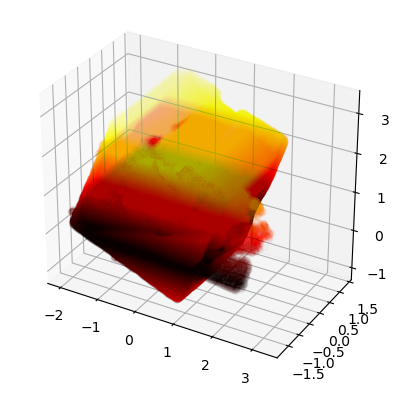

In [4]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mat[:,0], mat[:,1], mat[:,2], zdir='z', c=np.abs(mat[:,2])/np.max(mat), alpha=0.01, cmap='hot')
ax.set_aspect('equal', adjustable='box')
plt.show()

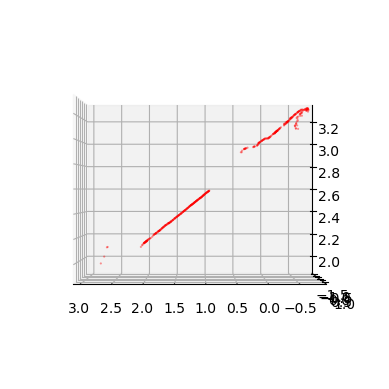

In [4]:
def find_ceiling(col, ssize):
    indices = np.zeros((1, 3))
    end = len(df[col]) // ssize
    ordf = df.sort_values(by=[col])
    for i in reversed(range(end)):
        temp = ordf[i*ssize:(i+1)*ssize]
        idx = temp[['By']].idxmax()
        current = df.iloc[idx].to_numpy()[0].copy()
        if np.max(indices[:,2]) < current[2]:
            indices = np.vstack((indices,current))
    indices = indices[1:,:]
    return indices

ind1 = find_ceiling('#', 250)
ind2 = find_ceiling('Exported', 250)
indices = np.vstack((ind1, ind2))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(indices[:,0], indices[:,1], indices[:,2], color='r', s=0.3, alpha=0.4)
ax.view_init(elev=0, azim=90)
plt.show()

Equation: 0 = 2.99 + -0.43x + -0.01y - z


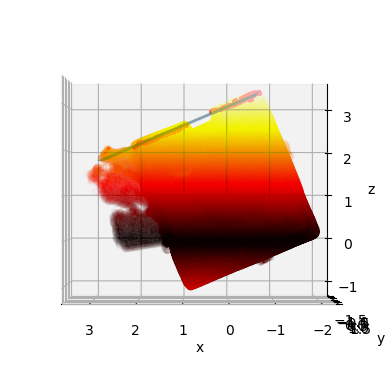

In [5]:
X_train = indices[:, :2]
y_train = indices[:, 2]
X_test = np.random.rand(200).reshape(100,2)*60

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, marker='.', color='red')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

model = lm.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

xrange = indices[:,0]
yrange = indices[:,1]

x = np.linspace(np.min(xrange), np.max(xrange))
y = np.linspace(np.min(yrange), np.max(yrange))

coefs = model.coef_
intercept = model.intercept_
xs = np.tile(x, (len(x),1))
ys = np.tile(y, (len(y),1)).T
zs = xs*coefs[0]+ys*coefs[1]+intercept
print("Equation: 0 = {:.2f} + {:.2f}x + {:.2f}y - z".format(intercept, coefs[0],
                                                          coefs[1]))

ax.plot_surface(xs,ys,zs, alpha=0.5)
ax.scatter(mat[:,0], mat[:,1], mat[:,2], zdir='z', c=np.abs(mat[:,2])/np.max(mat), alpha=0.01, cmap='hot')
ax.set_aspect('equal', 'box')
ax.view_init(elev=0, azim=90)
plt.show()

In [55]:
def create_rot_mat(coefs):
    norm = -np.array([coefs[0], coefs[1], -1])
    norm = norm / np.linalg.norm(norm)
    basis_x = np.array([1, 0, 0])
    axis = np.cross(norm, basis_x)
    axis = axis / np.linalg.norm(axis)
    angle = -np.arccos(np.dot(norm, basis_x))
    C = np.array([[0, -axis[2], axis[1]],
                [axis[2], 0, -axis[0]],
                [-axis[1], axis[0], 0]])
    return np.identity(3) + np.sin(angle)*C + (1-np.cos(angle))*np.dot(C, C)

rot_mat = create_rot_mat(coefs)
inv_rot = np.linalg.inv(rot_mat)
mat2d = np.dot(inv_rot, mat.T).T

ceil = mat2d[mat2d[:, 2].argsort()[:80000]][:,:2]

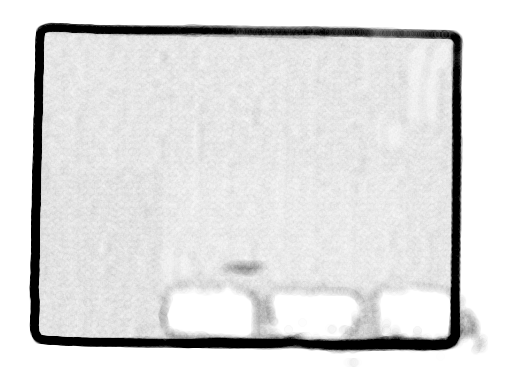

In [176]:
%matplotlib inline

plt.scatter(ceil[:,0], ceil[:, 1], color='k', alpha=0.002)
plt.axis('off')
plt.savefig('img.png')

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(mat2d[:,0], mat2d[:,1], mat2d[:,2], c=np.abs(mat2d[:,2])/np.max(mat2d), alpha=0.01, cmap='hot')
# # ax.scatter(mat[:,0], mat[:,1], mat[:,2], zdir='z', c=np.abs(mat[:,2])/np.max(mat), alpha=0.01, cmap='viridis')
# ax.view_init(elev=0, azim=0)
# plt.show

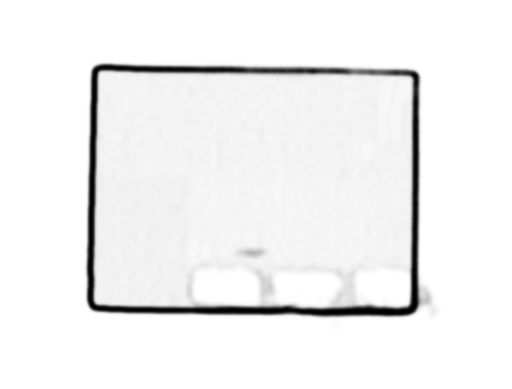

In [189]:
image = cv2.imread('img.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9, 9), 0)
sigma = np.std(blur)
mean = np.mean(blur)
lower = int(max(0, (mean - sigma)))
upper = int(min(255, (mean + sigma)))

edge = cv2.Canny(blur, lower, upper)
# edge = np.uint8((255 - cv2.Canny(gray, 200, 300, apertureSize=3)) // 255)
plt.imshow(blur, cmap='Greys_r')
plt.axis('off')
plt.show()

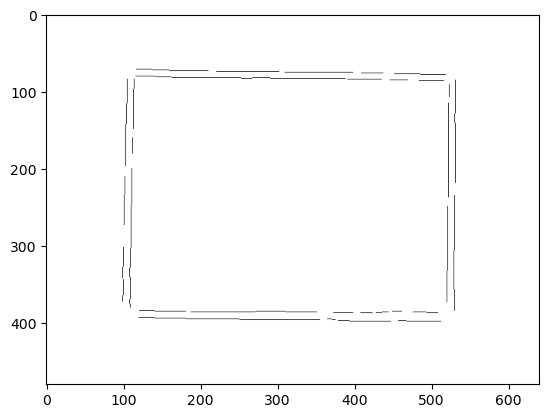

In [211]:
lines = probabilistic_hough_line(edge, threshold=2, line_length=10, line_gap=1)
restored = np.zeros_like(edge, dtype=np.uint8)
for line in lines:
    p0, p1 = line
    rr, cc = draw.line(p0[1], p0[0], p1[1], p1[0])
    restored[rr, cc] += 1
plt.imshow(restored, cmap='Greys')
# plt.axis('off')

/home/ilkin/anaconda3/envs/datasci/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


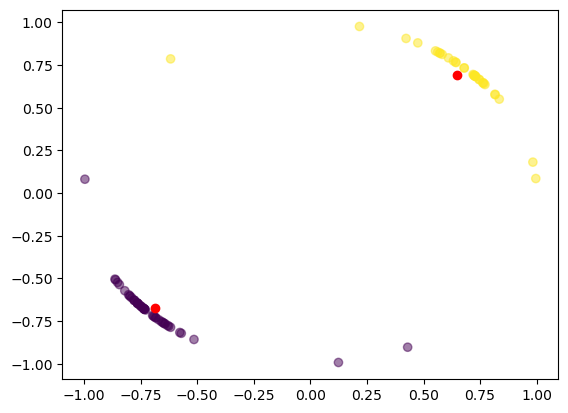

In [272]:
# gradients = np.array([(i[1][1]-i[1][0])/(i[0][1]-i[0][0]) for i in lines])
# plt.scatter(gradients, np.ones_like(gradients), alpha=0.4)
length = len(lines)
starts = np.array([[i[0][0],i[0][1]] for i in lines])
grad = np.array([[i[0][1]-i[0][0],i[1][1]-i[1][0]] for i in lines])
norms = np.sqrt(grad[:,0]**2 + grad[:,1]**2)[:, np.newaxis]
norms = np.hstack((norms, norms))
grad = grad / norms

km = KMeans(n_clusters=2)
km.fit(grad)
km.predict(grad)
labels = km.labels_

class_grad = np.hstack((grad, labels[:, np.newaxis]))
class_size = np.hstack((starts, labels[:, np.newaxis]))

b0 = np.mean(class_grad[class_grad[:,2] == 0.][:,:2], axis=0)
b1 = np.mean(class_grad[class_grad[:,2] == 1.][:,:2], axis=0)

plt.scatter(grad[:,0], grad[:,1], c=labels, alpha=0.5)
plt.scatter(b0[0], b0[1], c='r')
plt.scatter(b1[0], b1[1], c='r')

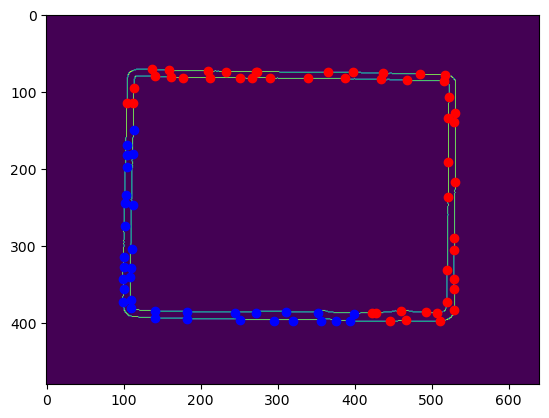

In [278]:
s0 = class_size[class_size[:,2] == 0.][:,:2] + b0
s1 = class_size[class_size[:,2] == 1.][:,:2] + b1
plt.scatter(s0[:,0], s0[:,1], c='r')
plt.scatter(s1[:,0], s1[:,1], c='b')
plt.imshow(edge)

(-0.5, 639.5, 479.5, -0.5)

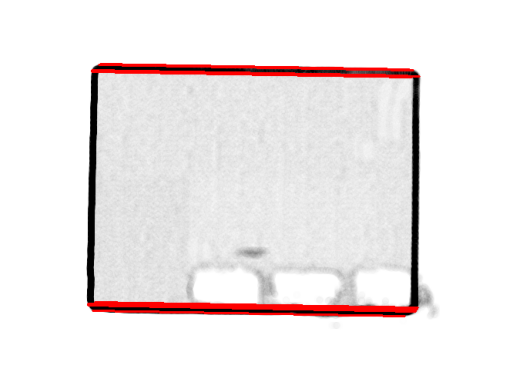

In [184]:
edge2 = edge.copy()
lines = cv2.HoughLinesP(edge2, 1, np.pi/180, 10, minLineLength=400, maxLineGap=1000)
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
# cv2.imshow("Polygon", edge2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(image)#, cmap='Greys_r')
plt.axis('off')

Number of contours detected: 1


(-0.5, 639.5, 479.5, -0.5)

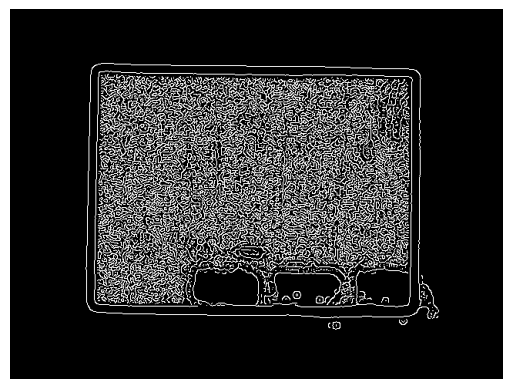

In [156]:
contours, hierarchy = cv2.findContours(edge, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_TC89_KCOS)
print("Number of contours detected:",len(contours))
edge3 = edge.copy()
for cnt in contours:
   approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
   (x,y)=cnt[0,0]
   if len(approx) <= 2:
      edge3 = cv2.drawContours(edge3, [approx], -1, (0,255,255), 3)
plt.imshow(edge3, cmap='Greys')
plt.axis('off')